<a href="https://colab.research.google.com/github/YoavTevet/animal-localization/blob/main/Animal_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Sources

In [ ]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from PIL import Image
from glob import glob
import random
import os
import cv2
from pathlib import Path
from keras.applications.vgg16 import preprocess_input
from google.colab import files
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.applications import VGG16

In [ ]:
# muonting to google drive
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/פרוייקט סיכום הנדסת תוכנה/"

Mounted at /content/drive


In [ ]:
# location for kaggle.json file
os.environ['KAGGLE_CONFIG_DIR'] = path
# location for download
%cd /tmp/
!kaggle datasets download -d alessiocorrado99/animals10
!unzip -qq -o animals10


/tmp
100% 583M/586M [00:27<00:00, 22.8MB/s]
100% 586M/586M [00:27<00:00, 22.6MB/s]


In [ ]:
# this is the source for the database.
# URL = 'https://www.kaggle.com/datasets/alessiocorrado99/animals10'

In [ ]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant",
             "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
             "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel",
             'sheep': 'pecora', "dog": "cane", "horse": "cavallo", "elephant" : "elefante",
             "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto",
             "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo", "ragno": "spider"}

# Overlap Calculating Function

In [ ]:
# calculate intersection over union
def localization_iou(y_true, y_pred):

    y_true = y_true.copy() #make a copy
    y_pred = y_pred.copy()

    y_true[:,2] +=y_true[:,0] #calculate y-high coordinate
    y_true[:,3] +=y_true[:,1] #calculate x-high coordinate

    y_pred[:,2] +=y_pred[:,0] #calculate y-high coordinate
    y_pred[:,3] +=y_pred[:,1] #calculate x-high coordinate

    # Calculate the coordinates of the intersection rectangle
    x_min = np.max([y_true[:, 0], y_pred[:,0]], axis=0)
    y_min = np.max([y_true[:, 1], y_pred[:, 1]], axis=0)
    x_max = np.min([y_true[:, 2], y_pred[:, 2]], axis=0)
    y_max = np.min([y_true[:, 3], y_pred[:, 3]], axis=0)

    # Calculate the area of intersection rectangle
    a = x_max - x_min
    b = y_max - y_min

    a = a * (a >= 0)
    b = b * (b >= 0)

    intersection_area = a * b

    # Calculate the area of the union rectangle
    y_true_area = (y_true[:, 2] - y_true[:, 0]) * (y_true[:, 3] - y_true[:, 1])
    y_pred_area = (y_pred[:, 2] - y_pred[:, 0]) * (y_pred[:, 3] - y_pred[:, 1])
    union_area = y_true_area + y_pred_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou


# Data Loading and preparation

In [ ]:
data_dir = '/tmp/raw-img/'
dir_names = os.listdir(data_dir)
print(len(dir_names))
print(dir_names)


10
['mucca', 'farfalla', 'ragno', 'gallina', 'gatto', 'cane', 'scoiattolo', 'pecora', 'cavallo', 'elefante']


In [ ]:

def resize_images(input_folder, output_folder, new_size=(250, 250)):
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through each file in the input folder
    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)

        # Check if the file is an image
        if os.path.isfile(input_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
            try:
                # Open the image
                with Image.open(input_path) as img:
                    # Resize the image
                    resized_img = img.resize(new_size)

                    # Save the resized image to the output folder
                    output_path = os.path.join(output_folder, filename)
                    resized_img.save(output_path)

                    # print(f"Resized {filename} successfully.")
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")



In [ ]:
# removing the classes "spider" and "butterfly" which I don't want to train on
shutil.rmtree(f"{data_dir}ragno")
shutil.rmtree(f"{data_dir}farfalla")

dir_names = os.listdir(data_dir)
print(len(dir_names))
print(dir_names)

8
['mucca', 'gallina', 'gatto', 'cane', 'scoiattolo', 'pecora', 'cavallo', 'elefante']


In [ ]:
animals = [translate[an] for an in dir_names]

animals

['cow', 'chicken', 'cat', 'dog', 'squirrel', 'sheep', 'horse', 'elephant']

In [ ]:
# normalize all the images to a smaller shape
# and put them in a new directory in the tmp server

input_dir = r'/tmp/raw-img/'

output_dir = r'/tmp/new/'


for animal in animals:
  resize_images(input_dir + translate[animal], output_dir + animal)
  print(f"done with {animal}")



done with cow
done with chicken
done with cat
done with dog
done with squirrel
done with sheep
done with horse
done with elephant


In [ ]:
def load_images_to_array(folder_path):
    # List to store images
    images = []

    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is an image
        if filename.endswith(('.png', '.jpg', '.jpeg', '.gif')):
            # Open the image file
            image_path = os.path.join(folder_path, filename)
            img = Image.open(image_path)

            # Convert image to numpy array
            img_array = np.array(img)

            # Append image array to the list
            # some images are shape (250, 250) which causes problems
            if img_array.shape == (250, 250, 3):
              images.append(img_array)

    # Convert the list of images into a numpy array
    images_array = np.array(images)

    return images_array



In [ ]:

folder_path = output_dir + animals[0]
images_array = load_images_to_array(folder_path)
cat_array = np.array([0 for i in range(images_array.shape[0])])
print("Images array shape:", images_array.shape)
print(f"done with {animals[0]}")



Images array shape: (1866, 250, 250, 3)
done with cow


In [ ]:
# adding all the other images to the numpy array

cat_eng = {0: animals[0], animals[0] : 0}
animals.pop(0)

for idx, animal in enumerate(animals):

  # builds the dictionary
  cat_eng[animal] = idx+1
  cat_eng[idx+1] = animal

  new_arr = load_images_to_array(output_dir + animal)
  images_array = np.concatenate((images_array, new_arr), axis=0)

  cat_array = np.concatenate((cat_array, np.array([idx+1 for _ in range(new_arr.shape[0])])))

  print(f"done with {animal}, IDX: {idx+1}")
  print(images_array.shape)
  print(cat_array.shape, cat_array[cat_array.shape[0] -1])
  print()

done with chicken, IDX: 1
(4964, 250, 250, 3)
(4964,) 1

done with cat, IDX: 2
(6631, 250, 250, 3)
(6631,) 2

done with dog, IDX: 3
(11494, 250, 250, 3)
(11494,) 3

done with squirrel, IDX: 4
(13356, 250, 250, 3)
(13356,) 4

done with sheep, IDX: 5
(15176, 250, 250, 3)
(15176,) 5

done with horse, IDX: 6
(17799, 250, 250, 3)
(17799,) 6

done with elephant, IDX: 7
(19235, 250, 250, 3)
(19235,) 7



# Data preparation for classifying network

In [ ]:
for i in range(8):
  print(cat_eng[i], i)

cow 0
chicken 1
cat 2
dog 3
squirrel 4
sheep 5
horse 6
elephant 7


0 horse


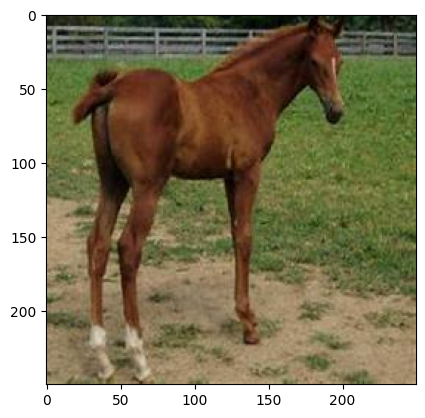

In [ ]:
print(cat_array[2568], cat_eng[cat_array[2568]])
plt.imshow(images_array[2568])

2 sheep


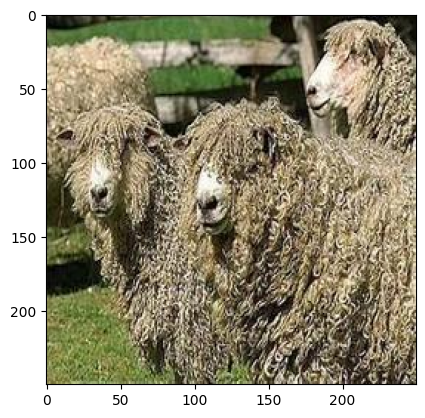

In [ ]:
print(cat_array[4859], cat_eng[cat_array[4859]])
plt.imshow(images_array[4859])

In [ ]:

x_train, x_test, y_train, y_test = train_test_split(images_array, cat_array, test_size=0.15)


x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)


print("x_train", x_train.shape)
print("x_test", x_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)



x_train (16349, 250, 250, 3)
x_test (2886, 250, 250, 3)
y_train (16349,)
y_test (2886,)


# Classification network without VGG

In [ ]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),  # Adding dropout to the fully connected layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),  # Adding dropout to the fully connected layer
        tf.keras.layers.Dense(8, activation='softmax')
    ])

    return model


model = create_model()


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 29, 29, 128)       0

In [ ]:
# This will train the mdel
my_callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9,restore_best_weights=True)

# model runs three epochs since this got me the lowest validation loss
history = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_split=0.1, callbacks=[my_callback_es])


Epoch 1/20
230/230 [==============================] - 22s 67ms/step - loss: 1.7158 - accuracy: 0.3707 - val_loss: 1.3974 - val_accuracy: 0.5003
Epoch 2/20
230/230 [==============================] - 11s 49ms/step - loss: 1.3461 - accuracy: 0.5203 - val_loss: 1.2367 - val_accuracy: 0.5670
Epoch 3/20
230/230 [==============================] - 11s 49ms/step - loss: 1.1628 - accuracy: 0.5891 - val_loss: 1.0659 - val_accuracy: 0.6318
Epoch 4/20
230/230 [==============================] - 11s 49ms/step - loss: 0.9981 - accuracy: 0.6459 - val_loss: 1.0808 - val_accuracy: 0.6367
Epoch 5/20
230/230 [==============================] - 11s 49ms/step - loss: 0.8829 - accuracy: 0.6927 - val_loss: 1.0448 - val_accuracy: 0.6416
Epoch 6/20
230/230 [==============================] - 11s 49ms/step - loss: 0.7366 - accuracy: 0.7393 - val_loss: 1.0835 - val_accuracy: 0.6349
Epoch 7/20
230/230 [==============================] - 11s 50ms/step - loss: 0.6206 - accuracy: 0.7812 - val_loss: 0.9684 - val_accuracy:

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')
print(f'Test Loss: {test_loss}')

91/91 [==============================] - 2s 15ms/step - loss: 0.9831 - accuracy: 0.6795
Test accuracy: 0.6794871687889099
Test Loss: 0.9830508232116699


# Classification network with VGG16

In [ ]:
# attempt at classification with VGG16

def create_vgg16_model(input_shape=(250, 250, 3), num_classes=8):
    # Load pre-trained VGG16 model without including the top fully connected layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the pre-trained weights
    for layer in base_model.layers:
        layer.trainable = False

    # Add new top layers for classification
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Create the new model
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Create the model
model = create_vgg16_model()

# Display the model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0     

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
my_callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9,restore_best_weights=True)
history_vgg = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_split=0.1, callbacks=[my_callback_es])


Epoch 1/20
230/230 [==============================] - 45s 163ms/step - loss: 1.1802 - accuracy: 0.7113 - val_loss: 0.5313 - val_accuracy: 0.8208
Epoch 2/20
230/230 [==============================] - 30s 132ms/step - loss: 0.3728 - accuracy: 0.8760 - val_loss: 0.4836 - val_accuracy: 0.8336
Epoch 3/20
230/230 [==============================] - 30s 132ms/step - loss: 0.1983 - accuracy: 0.9390 - val_loss: 0.4730 - val_accuracy: 0.8502
Epoch 4/20
230/230 [==============================] - 30s 132ms/step - loss: 0.1285 - accuracy: 0.9624 - val_loss: 0.4619 - val_accuracy: 0.8581
Epoch 5/20
230/230 [==============================] - 30s 132ms/step - loss: 0.0668 - accuracy: 0.9853 - val_loss: 0.5113 - val_accuracy: 0.8361
Epoch 6/20
230/230 [==============================] - 30s 132ms/step - loss: 0.0319 - accuracy: 0.9963 - val_loss: 0.4915 - val_accuracy: 0.8569
Epoch 7/20
230/230 [==============================] - 30s 132ms/step - loss: 0.0157 - accuracy: 0.9993 - val_loss: 0.4994 - val_ac

In [ ]:
x_train.shape

(16349, 250, 250, 3)

In [ ]:
x_test.shape

(2886, 250, 250, 3)

In [ ]:
# Evaluate the model on the test set

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')
print(f'Test Loss: {test_loss}')

91/91 [==============================] - 6s 63ms/step - loss: 0.5328 - accuracy: 0.8358
Test accuracy: 0.8357588648796082
Test Loss: 0.5327668190002441


# Localization and classification

## Generator

In [ ]:
batch_size = 32
steps_per_epoch = 60 #how many batches per epoch
epochs = 10
animal_size = (250, 250, 3)


In [ ]:
# backgrounds
!wget -q 'https://raw.githubusercontent.com/arielb30/pokemon/main/backgrounds.zip'
!unzip -q -n backgrounds.zip

In [ ]:
backgrounds = []
background_files = glob('backgrounds/*.jpg')
for f in background_files:
  # open and resize backgrounds
  bg = Image.open(f).resize((224, 224))  # images are originally shaped 224 by 350 ish
  backgrounds.append(np.array(bg))

In [ ]:
for bg in backgrounds:
  print(bg.shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [ ]:
bg = backgrounds[0]
bg.shape

(224, 224, 3)

In [ ]:
# this is the generator


def animal_generator_multiclass():
  # generate image and targets
  while True:
    for _ in range(steps_per_epoch):
      X = np.zeros((batch_size, bg.shape[0], bg.shape[1], 3)) # the background
      Y_bbox = np.zeros((batch_size, 4))  # the location in 4 nums
      Y_cat = np.zeros((batch_size,),dtype=int)

      for i in range(batch_size):
        X[i] = random.choice(backgrounds) #random background


        # choose a random animal
        animal_idx = np.random.randint(images_array.shape[0])
        animal_category = cat_array[animal_idx] # the category of the animal
        animal = images_array[animal_idx] # the data
        anh, anw = animal.shape[0], animal.shape[1] # animal height and width

        # resize the animal (should be between 75 by 75 to 125 by 125)
        scale = 0.3 + (np.random.random() * 0.2)  # random number between 0.3 and 0.5

        # updates the height and width according to scale
        new_height = int(anh * scale)
        new_width = int(anw * scale)

        # resize the object that is being worked on
        an = Image.fromarray(animal, 'RGB')
        an = an.resize((new_width, new_height))
        an = np.array(an)

        # maybe flip
        if np.random.random() < 0.5:
          an = np.fliplr(an)

        # choose a random location for the animal on the background
        # we subtract height and width to make sure location is within
        # the background image
        row0 = np.random.randint(bg.shape[0] - new_height)
        col0 = np.random.randint(bg.shape[1] - new_width)
        row1 = row0 + new_height
        col1 = col0 + new_width

        # put the animal in teh background
        X[i, row0:row1, col0:col1, :] = an

        # this is the boundaries of the aminal which is on the background
        Y_bbox[i,0] = row0/bg.shape[0]
        Y_bbox[i,1] = col0/bg.shape[0]
        Y_bbox[i,2] = (row1 - row0)/bg.shape[0]
        Y_bbox[i,3] = (col1 - col0)/bg.shape[0]

        Y_cat[i] = animal_category

      yield X, (Y_bbox,Y_cat)

In [ ]:
X, (Y_bbox, Y_cat) = next(animal_generator_multiclass())
print(X.shape,Y_bbox.shape,Y_cat.shape)

(32, 224, 224, 3) (32, 4) (32,)


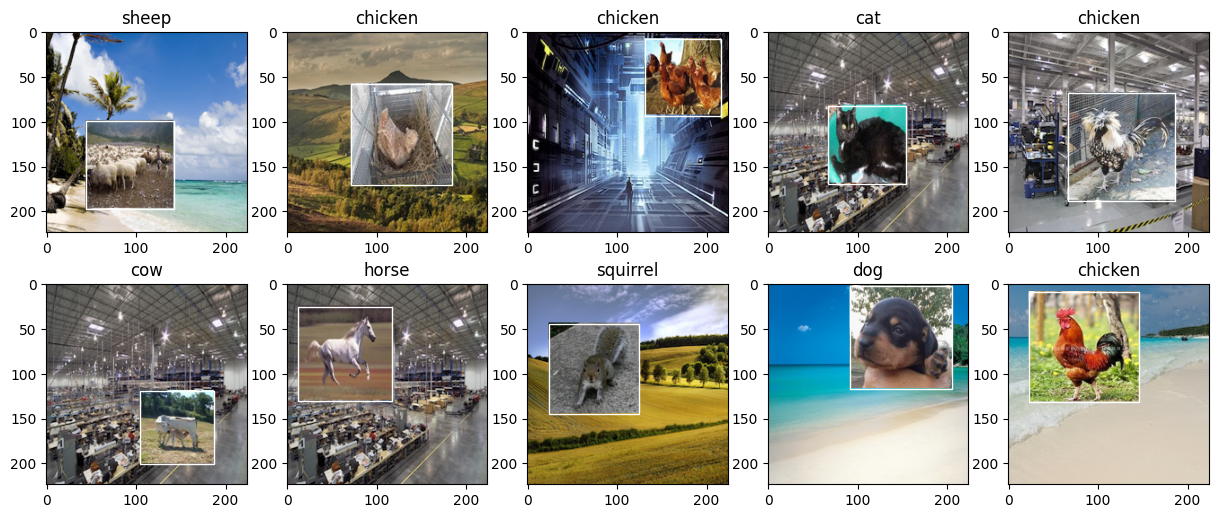

In [ ]:
sample = np.random.choice(np.arange(X.shape[0]), size=10, replace=False)
plt.figure(figsize=(15, 6)) #שטח התצוגה
for i, idx in enumerate(sample):
  x = X[idx]
  y_bbox = Y_bbox[idx]
  y_cat = Y_cat[idx]
  ax = plt.subplot(2, 5, i + 1)

  ax.imshow(x.astype(np.uint8))
  rect = Rectangle( #labels
    (y_bbox[1]*bg.shape[0], y_bbox[0]*bg.shape[0]),
    y_bbox[3]*bg.shape[0], y_bbox[2]*bg.shape[0],linewidth=1,edgecolor='w',facecolor='none')
  ax.add_patch(rect)
  plt.title(f"{cat_eng[y_cat]}",fontsize=12)

## Network

In [ ]:
vgg = tf.keras.applications.VGG16(
    input_shape=(bg.shape[0], bg.shape[1], 3),
    include_top=False,
    weights='imagenet')


vgg.summary()



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def make_model():
  inputs = Input(shape=(bg.shape[0], bg.shape[1], 3))
  x = preprocess_input(inputs)
  x = vgg(x) #VGG feature extractor
  x = Flatten()(x) #prepare for dense
  x = Dense(32, activation='relu')(x) #dense with relu
  bbox_output = Dense(4,activation='sigmoid', name = 'bbox')(x) #Dense with sigmoid
  cat_output = Dense(8,activation='softmax',name = 'cat')(x) #Dense with softmax
  model = Model(inputs, outputs = [bbox_output, cat_output]) #create model
  return model

In [ ]:
model=make_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem_1  (None, 224, 224, 3)          0         ['input_4[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)          0         ['tf.__operators__.getitem_1[0
 da)                                                                ][0]']                        
                                                                                            

In [ ]:
LossFunc    =     {'bbox':'binary_crossentropy', 'cat':'sparse_categorical_crossentropy', }
lossWeights =     {'bbox':100.0, 'cat':1.0, }

model.compile(optimizer=Adam(learning_rate=1e-4),#adam
              loss=LossFunc,
              loss_weights=lossWeights,
              metrics = {'cat' : 'accuracy'}) #add accuracy metrics

In [ ]:
model.fit(
    animal_generator_multiclass(),
    steps_per_epoch=steps_per_epoch,
    epochs=40,
)

Epoch 1/40
60/60 [==============================] - 4s 67ms/step - loss: 61.7077 - bbox_loss: 0.5967 - cat_loss: 2.0344 - cat_accuracy: 0.2464
Epoch 2/40
60/60 [==============================] - 4s 66ms/step - loss: 61.9267 - bbox_loss: 0.5990 - cat_loss: 2.0248 - cat_accuracy: 0.2323
Epoch 3/40
60/60 [==============================] - 4s 67ms/step - loss: 61.7207 - bbox_loss: 0.5970 - cat_loss: 2.0196 - cat_accuracy: 0.2359
Epoch 4/40
60/60 [==============================] - 4s 66ms/step - loss: 62.0052 - bbox_loss: 0.5998 - cat_loss: 2.0240 - cat_accuracy: 0.2464
Epoch 5/40
60/60 [==============================] - 4s 67ms/step - loss: 61.9373 - bbox_loss: 0.5990 - cat_loss: 2.0332 - cat_accuracy: 0.2422
Epoch 6/40
60/60 [==============================] - 4s 67ms/step - loss: 61.5501 - bbox_loss: 0.5953 - cat_loss: 2.0201 - cat_accuracy: 0.2526
Epoch 7/40
60/60 [==============================] - 4s 67ms/step - loss: 61.9165 - bbox_loss: 0.5991 - cat_loss: 2.0102 - cat_accuracy: 0.2448

In [ ]:
# sometimes the first 40 epochs are not enough so we keep on training the model
model.fit(
    animal_generator_multiclass(),
    steps_per_epoch=steps_per_epoch,
    epochs=40,
)


Epoch 1/40
60/60 [==============================] - 4s 67ms/step - loss: 61.2053 - bbox_loss: 0.5980 - cat_loss: 1.4054 - cat_accuracy: 0.4630
Epoch 2/40
60/60 [==============================] - 4s 68ms/step - loss: 60.9679 - bbox_loss: 0.5963 - cat_loss: 1.3404 - cat_accuracy: 0.4828
Epoch 3/40
60/60 [==============================] - 4s 69ms/step - loss: 60.8624 - bbox_loss: 0.5953 - cat_loss: 1.3296 - cat_accuracy: 0.4922
Epoch 4/40
60/60 [==============================] - 4s 67ms/step - loss: 61.0349 - bbox_loss: 0.5976 - cat_loss: 1.2706 - cat_accuracy: 0.5078
Epoch 5/40
60/60 [==============================] - 4s 68ms/step - loss: 61.0716 - bbox_loss: 0.5980 - cat_loss: 1.2697 - cat_accuracy: 0.5130
Epoch 6/40
60/60 [==============================] - 4s 67ms/step - loss: 61.2660 - bbox_loss: 0.5995 - cat_loss: 1.3117 - cat_accuracy: 0.5016
Epoch 7/40
60/60 [==============================] - 4s 67ms/step - loss: 61.1220 - bbox_loss: 0.5988 - cat_loss: 1.2458 - cat_accuracy: 0.5146

# performance evaluation

In [ ]:
X, (Y_bbox, Y_cat) = next(animal_generator_multiclass())
print(X.shape,Y_bbox.shape,Y_cat.shape)

(32, 224, 224, 3) (32, 4) (32,)


In [ ]:
(pred_bbox,pred_cat) = model.predict(X) #predict on X
print(pred_bbox.shape,pred_cat.shape)

1/1 [==============================] - 0s 31ms/step
(32, 4) (32, 8)


In [ ]:
#average IOU for all examples
iou = localization_iou(y_true=Y_bbox,y_pred=pred_bbox)
np.mean(iou)

0.901262602263897

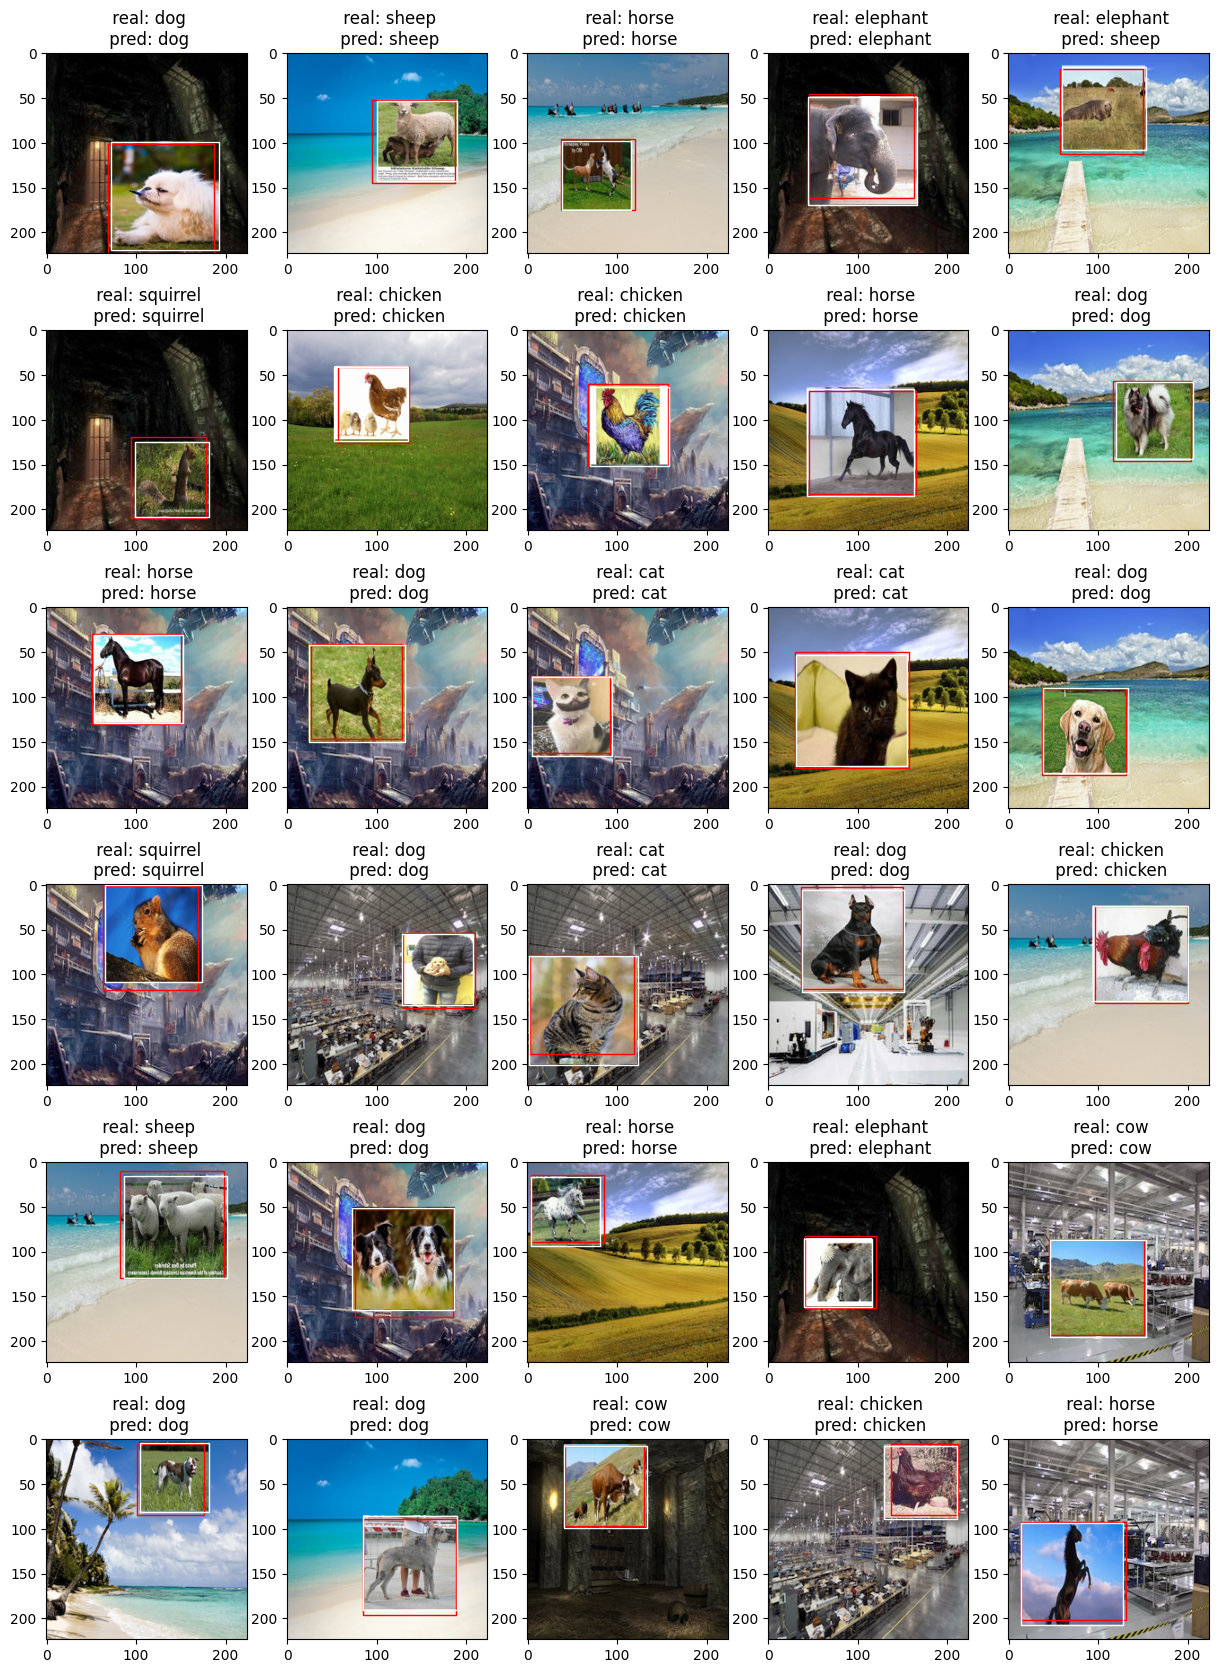

In [ ]:
sample = np.random.choice(np.arange(X.shape[0]), size=30, replace=False)
plt.figure(figsize=(15, 21)) #שטח התצוגה
for i, idx in enumerate(sample):
  x = X[idx]
  y_cat = Y_cat[idx]
  y_bbox = Y_bbox[idx]

  p_cat = np.argmax(pred_cat[idx])
  p_bbox = pred_bbox[idx]
  ax = plt.subplot(6, 5, i + 1)

  # Draw the box
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle( #predictions
    (p_bbox[1]*bg.shape[0], p_bbox[0]*bg.shape[0]),
    p_bbox[3]*bg.shape[0], p_bbox[2]*bg.shape[0],linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)

  rect = Rectangle( #labels
    (y_bbox[1]*bg.shape[0], y_bbox[0]*bg.shape[0]),
    y_bbox[3]*bg.shape[0], y_bbox[2]*bg.shape[0],linewidth=1,edgecolor='w',facecolor='none')
  ax.add_patch(rect)

  plt.title(f" real: {cat_eng[y_cat]}\n pred: {cat_eng[p_cat]}",fontsize=12)